<h1><center> GCR SpecGen </center></h1>

Welcome to GCR SpecGen!  This is a Jupyter notebook for conveniently generating GCR spectra.

For more information about the model, see: https://www.sciencedirect.com/science/article/pii/S0273117712005947?via%3Dihub

### Setup instructions

There are a few steps you need to take before using this tool if this is your first session of this Jupyter notebook.  Above and on the right side of this body of text should be a small box which either says 'Trusted' or 'Not Trusted' inside it.  If this notebook is already trusted, then great!  If not, click the 'Not Trusted' box and confirm that you trust this notebook in the menu that appears.  This Jupyter notebook uses HTML and JavaScript for a few things to make using this notebook as clean an experience as possible and to allow cells, the individual units containing all of the code and UI elements below, to update by just pressing the buttons on the page (rather than having to manually run the cells), making this page usable by anyone regardless of their proficiency in any of these languages.

After the notebook is trusted, all of the following cells need to be initialized.  Either click the 'restart kernal and re-run whole notebook' button above ( &#9193; ) or run the first few cells manually by either clicking the 'Run' button above or pressing Shift+Enter a few times and then clicking the green "Initialize code" button below once it has been initialized.  This procedure will only need to be performed once for each time the Jupyter notebook is launched.

In [1]:
%matplotlib notebook
from IPython.display import HTML, display, Javascript, Math
import numpy as np
import matplotlib.pyplot as plt
import re
import ipywidgets as w
import unicodedata as ud
import zipfile as zf
#import tabulate

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<style>
 div.cell{
        width:100%;
        padding-top:0%;
        padding-bottom:0%;
        }
 .prompt {
    min-width: 10ex;}
</style>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')


In [2]:
'''
This code serves to quickly generate GCR spectra for ions with Z=1-28 using the Matthia model
https://www.sciencedirect.com/science/article/pii/S0273117712005947?via%3Dihub
'''

def slugify(value):
    """
    Normalizes string, converts to lowercase, removes non-alpha characters,
    and converts spaces to hyphens.
    """
    value = str(ud.normalize('NFKD', value).encode('ascii', 'ignore'))
    value = str(re.sub('[^\w\s-]', '', value).strip().lower())
    value = str(re.sub('[-\s]+', '-', value))
    return value

def on_click(change):
    #display(Javascript('IPython.notebook.execute_cells_below()'))  
    #display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))
    #display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, 6)'))
    display(Javascript('IPython.notebook.execute_cells'))

def on_click_run_all(change):
    display(Javascript('IPython.notebook.execute_cells_below()'))
    
def on_click_next(change):
    display(Javascript('IPython.notebook.execute_cells([IPython.notebook.get_selected_index()+1])'))

def on_click_calcs(change):
    display(Javascript('IPython.notebook.execute_cells([4,5,6,7])'))

def on_click_67(change):
    display(Javascript('IPython.notebook.execute_cells([6,7])'))

def gen_generic_save_file_button():
    generic_save_file_button = w.Button(
        description='Save file (txt)',
        disabled=False,
        button_style='success', # 'success', 'info', 'warning', 'danger' or ''
        tooltip='Save a text file with information of the this spectrum ('+plotted_spectra_names[i][j]+') in the local text_files/ folder',
        icon='save' # pencil, rotate-right
    )
    return generic_save_file_button
    
def on_click_save_text_files(change):
    arc_fname = r'text_files/' + window_title + '.zip'
    zfile = zf.ZipFile(arc_fname, mode='w',compression=zf.ZIP_DEFLATED)
    for i in range(len(plotted_spectra_names)):
        for j in range(len(plotted_spectra_names[i])):
            txtname = plotted_spectra_names[i][j] + '.txt'
            zfile.writestr(txtname,plotted_spectra_text[i][j].replace('\n','\r\n'))
    zfile.close()
    update_print_str = 'ZIP archive of text files saved to: '+arc_fname
    print(update_print_str) # print saved note
    
    
def calc_GCR_intensity(Z,W,E):
    '''
    Calculate GCR flux for a given ion at a given energy
    Inputs:
       - Z: GCR ion Z
       - W: solar modulation parameter
       - E: GCR ion energy (in MeV/n)
    Outputs: 
       - IOSI: ion flux in (s*sr*cm^2*MeV/n)^-1
    '''
    
    if Z<1 or Z>28 or W<0 or W>200:
        return -99
    if E<10:
        return 0
    
    AI = [1.0 ,4.0,  6.9,  9.0, 10.8, 12.0, 14.0, 16.0, 19.0, 20.2, 23.0, 24.3, 27.0, 28.1, 31.0, 32.1, 35.4, 39.9, 39.1, 40.1, 44.9, 47.9, 50.9, 52.0, 54.9, 55.8, 58.9, 58.7]
    CI = [1.85e4, 3.69e3, 19.5, 17.7, 49.2, 103.0, 36.7, 87.4, 3.19, 16.4, 4.4300, 19.300, 4.17, 13.4, 1.15, 3.060, 1.30, 2.33, 1.87, 2.17, 0.74, 2.63, 1.23, 2.12, 1.14, 9.32, 0.10, 0.48]
    gammaI = [2.74, 2.77, 2.82, 3.05, 2.96, 2.76, 2.89, 2.70, 2.82, 2.76, 2.84, 2.70, 2.77, 2.66, 2.89, 2.71, 3.00, 2.93, 3.05, 2.77, 2.97, 2.99, 2.94, 2.89, 2.74, 2.63, 2.63, 2.63]
    alphaI = [2.85, 3.12, 3.41, 4.30, 3.93, 3.18, 3.77, 3.11, 4.05, 3.11, 3.14, 3.65, 3.46, 3.00, 4.04, 3.30, 4.40, 4.33, 4.49, 2.93, 3.78, 3.79, 3.50, 3.28, 3.29, 3.01, 4.25, 3.52]
    
    P = [0.02,4.7]
    
    i = int(Z-1)
    
    E0S = 938.0 # rest mass in MeV/n
    if Z>1: E0S = 939.0 # rest mass in MeV/n
    E0SS = E0S/1000 # rest mass in GeV/n
    ES = E/1000 # energy in GeV/n
    RigS = (AI[i]/Z*np.sqrt(ES*(ES+2*E0SS))) #rigidity in GV
    betaS2 = (np.sqrt(ES*(ES+2.*E0SS))/(ES+E0SS)) #convert kinetic energy per nucleon to beta=v/c
    R0S = (0.37+0.0003*(W**1.45))
    DELTAI = (P[1]+P[0]*W)
    PHII = CI[i]*(betaS2**alphaI[i])/(RigS**gammaI[i])
    PHII = PHII*((RigS/(RigS+R0S))**DELTAI)
    IOSI = 0.0001*PHII*AI[i]/Z*0.001/betaS2
    
    return IOSI
    
def assemble_GCR_flux(W,nEbins=1000):
    '''
    Composes a NumPy array containing GCR flux from 10 MeV/n to 1 TeV/n for each GCR ion with Z=1-28
    Inputs:
       - W: solar modulation parameter
    Outputs:
       - GCR_flux(28,4,1000) - array containing flux values in (s*sr*cm^2*MeV/n)^-1 ; [emin/emid/emax/flux]
    '''
    GCR_flux = np.zeros((28,4,nEbins))
    
    Emin = 10 # MeV
    Emax = 1e6 # MeV
    
    logEmin = np.log10(Emin)
    logEmax = np.log10(Emax)
    logdE = (logEmax-logEmin)/nEbins
    logE = logEmin
    
    for k in range(nEbins):
        GCR_flux[:,0,k] = 10**(logE)
        GCR_flux[:,1,k] = 10**(logE+0.5*logdE)
        GCR_flux[:,2,k] = 10**(logE+logdE)
        logE += logdE
    
    for j in range(28):
        Z = j+1
        for k in range(nEbins):
            GCR_flux[j,3,k] = calc_GCR_intensity(Z,W,GCR_flux[j,1,k])
            
    return GCR_flux  


all_iso_strs = ['1H','4He','7Li','9Be','11B','12C','14N','16O','19F','20Ne','23Na','24Mg','27Al','28Si','31P','32S','35Cl','40Ar','39K','40Ca','45Sc','48Ti','51V','52Cr','55Mn','56Fe','59Co','59Ni']
all_iso_strs_TeX = [r'$^{1}_{1}$H',r'$^{4}_{2}$He',r'$^{7}_{3}$Li',r'$^{9}_{4}$Be',r'$^{11}_{5}$B',r'$^{12}_{6}$C',r'$^{14}_{7}$N',r'$^{16}_{8}$O',r'$^{19}_{9}$F',r'$^{20}_{10}$Ne',r'$^{23}_{11}$Na',r'$^{24}_{12}$Mg',r'$^{27}_{13}$Al',r'$^{28}_{14}$Si',r'$^{31}_{15}$P',r'$^{32}_{16}$S',r'$^{35}_{17}$Cl',r'$^{40}_{18}$Ar',r'$^{39}_{19}$K',r'$^{40}_{20}$Ca',r'$^{45}_{21}$Sc',r'$^{48}_{22}$Ti',r'$^{51}_{23}$V',r'$^{52}_{24}$Cr',r'$^{55}_{25}$Mn',r'$^{56}_{26}$Fe',r'$^{59}_{27}$Co',r'$^{59}_{28}$Ni']
all_Z_strs = ['H','He','Li','Be','B','C','N','O','F','Ne','Na','Mg','Al','Si','P','S','Cl','Ar','K','Ca','Sc','Ti','V','Cr','Mn','Fe','Co','Ni']
A_list = [1,4,7,9,11,12,14,16,19,20,23,24,27,28,31,32,35,40,39,40,45,48,51,52,55,56,59,59]


update_print_str = ""
checkTF = False
currently_updating_fig_dims = False
zoom_mult = 1 # default zoom level to reset to



run_all_label = w.Label(value='(This button also resets everything in this code to its default state.)')

run_all_cells_button = w.Button(
    description='Initialize code',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to load all of the code cells if not already loaded.',
    icon='play' # pencil, rotate-right, paint-brush
)

display(w.HBox([run_all_cells_button,run_all_label]))
run_all_cells_button.on_click(on_click_run_all)


HBox(children=(Button(button_style='success', description='Initialize code', icon='play', style=ButtonStyle(), tooltip='Click to load all of the code cells if not already loaded.'), Label(value='(This button also resets everything in this code to its default state.)')))

In [3]:
display(HTML('<hr>'))

#W = 50
nEbins = 1000

W_slider = w.FloatSlider(
    description='W',
    min=0,
    max=200,
    step=1.0,
    value = 50,
)
W_text = w.FloatText(step=1.0,layout=w.Layout(width='12%'))

# Add text box for control over number of energy bins

make_plot_button = w.Button(
    description='Update value',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to redraw the plot below with updated options from above.',
    icon='refresh' # pencil, rotate-right, paint-brush, refresh
)

display(w.HBox([W_slider,W_text,make_plot_button]))
w_link = w.jslink((W_slider, 'value'), (W_text, 'value'))

#display(make_plot_button)
make_plot_button.on_click(on_click_calcs)

display(HTML('<hr>'))

HBox(children=(FloatSlider(value=50.0, description='W', max=200.0, step=1.0), FloatText(value=0.0, layout=Layout(width='12%'), step=1.0), Button(button_style='success', description='Update value', icon='refresh', style=ButtonStyle(), tooltip='Click to redraw the plot below with updated options from above.')))

In [4]:
# Collect and calculate values based on user input

W = (W_slider.value)
W_text = ('{:g}'.format(W)).replace('.','p')

GCR_flux = assemble_GCR_flux(W,nEbins)

integral_flux = []
for i in range(28):
    integral_flux.append(np.sum(GCR_flux[i,3,:]*(GCR_flux[i,2,:]-GCR_flux[i,0,:])))
integral_flux = np.array(integral_flux)



In [5]:
# Table

# Useful meta information
#   Total particle flux (by ion and total)

s_per_d = 60*60*24
s_per_y = 365.25*s_per_d

table = [['Z',r'A$^*$','ID',r'$\phi$ [#/(s$\cdot$sr$\cdot$cm$^2$)]',r'$\phi$ [#/(d$\cdot$sr$\cdot$cm$^2$)]',r'$\phi$ [#/(yr$\cdot$sr$\cdot$cm$^2$)]','Percent (%)']]
for i in range(28):
    table.append([str(i+1),
                  str(A_list[i]),
                  all_Z_strs[i],
                  '{:.5E}'.format(integral_flux[i]),
                  '{:.5E}'.format(integral_flux[i]*s_per_d),
                  '{:.5E}'.format(integral_flux[i]*s_per_y),
                  '{:.4E}'.format(100*integral_flux[i]/np.sum(integral_flux))])
    
table.append(['','','All',
              '{:.5E}'.format(np.sum(integral_flux)),
              '{:.5E}'.format(np.sum(integral_flux)*s_per_d),
              '{:.5E}'.format(np.sum(integral_flux)*s_per_y),
              '{:.4E}'.format(100*np.sum(integral_flux)/np.sum(integral_flux))])
    
display(HTML('Integral GCR ion fluxes for W = {:g}'.format(W))) # $W={{{:}}}$'.format(str(W)))) # fancy W=XX text

display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in table)
       )
))

display(HTML(r'$^*$A = average atomic mass rounded to nearest integer'))


#display(HTML(tabulate.tabulate(table, tablefmt='html')))
#display(Math(all_iso_strs_TeX[7].replace('$','')))



In [6]:
# Expandable menu with spectra (raw/PHITS/MCNP)

spectra_text_label = w.Label(value='For convenience, the GCR spectra can be viewed and saved in the tabs below. (MCNP and PHITS input still under development)')
display(spectra_text_label)

plotted_spectra_text = [[],[],[]]
plotted_spectra_names = [[],[],[]]

ion_names = []
for i in range(28):
    ion_names.append('Z-'+str(i+1)+'-'+all_Z_strs[i]+'_')
name_bases = ['All-Z-1-28_'] + ion_names

name_suffixes = ['raw','MCNP','PHITS']

column_headers = ['Emin [MeV/n]','Emid [MeV/n]','Emax [MeV/n]','Flux [#/(s*sr*cm^2*MeV/n)]']

for i in range(3):
    for j in range(29):
        plotted_spectra_names[i].append('GCR-flux_W-' + W_text +'_'+ name_bases[j] + name_suffixes[i])
        
        if j==0: # All ions
            text = "Flux F in units of [#/(s*sr*cm^2*MeV/n)]\n"
            text += column_headers[0]+'\t'+column_headers[1]+'\t'+column_headers[2]+'\t'
            for zi in range(28):
                text += 'F(Z={0}/{1})\t'.format(str(zi+1),all_Z_strs[zi])
            text = text[:-1]+'\n' # replace last tab with newline
            
            for ei in range(nEbins):
                text += '{0:.8E}\t{1:.8E}\t{2:.8E}\t'.format(GCR_flux[0,0,ei],GCR_flux[0,1,ei],GCR_flux[0,2,ei])
                for zi in range(28):
                    text += '{0:.8E}\t'.format(GCR_flux[zi,3,ei])
                text = text[:-1]+'\n' # replace last tab with newline
            
        if j!=0: # Individual ions
            text = ""
            text += column_headers[0]+'\t'+column_headers[1]+'\t'+column_headers[2]+'\t'+column_headers[3]+'\n'
            for ei in range(nEbins):
                text += '{0:.8E}\t{1:.8E}\t{2:.8E}\t{3:.8E}\n'.format(GCR_flux[j-1,0,ei],GCR_flux[j-1,1,ei],GCR_flux[j-1,2,ei],GCR_flux[j-1,3,ei])
        
        plotted_spectra_text[i].append(text)
        
        
#print(mm_raw_text[0,2,0,0,0,0,0])

tab_names = ['Experiment','MCNP','PHITS']
tab_accordions = [[],[],[]]
accordions_list = []


save_file_buttons_list = [[],[],[]]

for i in range(len(plotted_spectra_names)):
    for j in range(len(plotted_spectra_names[i])):
        text = '<font size="2"><p style="line-height:1.4; font-family: monospace">' + plotted_spectra_text[i][j].replace('\n','<br>') + '</p></font>'
        textbox = w.HBox([w.HTML(value=text)], layout=w.Layout(height='400px', overflow_y='auto',width='1800px', overflow_x='auto'))
        
        save_file_buttons_list[i].append(gen_generic_save_file_button())
        #save_file_buttons_list[i][j].on_click(on_click_save_a_text_file)
        
        tab_accordions[i].append(w.VBox([textbox,save_file_buttons_list[i][j]]))
        
        
        
    temp_acc = w.Accordion(children=tab_accordions[i],selected_index=None) # ,layout=w.Layout(collapsed=True)
    for j in range(len(plotted_spectra_names[i])):
        temp_acc.set_title(j, plotted_spectra_names[i][j])
        
    accordions_list.append(temp_acc)


tab_nest = w.Tab()
tab_nest.children = accordions_list
tab_nest.set_title(0, tab_names[0])
tab_nest.set_title(1, tab_names[1])
tab_nest.set_title(2, tab_names[2])

display(tab_nest)

# Save individual files

# make individual save functions
save_funcions_array = [[],[],[]]
for i in range(len(plotted_spectra_names)):
    for j in range(len(plotted_spectra_names[i])):
        fname = r'text_files/' + plotted_spectra_names[i][j] + '.txt'
        fcontents = plotted_spectra_text[i][j]
        update_print_str = 'Text file saved to: '+ fname
        def function_builder(fname,fcontents,update_print_str):
            def on_click_save_a_text_file(change):
                f = open(fname,'w')
                f.write(fcontents)
                f.close()
                print(update_print_str) # print saved note
            return on_click_save_a_text_file
        save_funcions_array[i].append(function_builder(fname,fcontents,update_print_str))
        
        save_file_buttons_list[i][j].on_click(save_funcions_array[i][j])

# Save files in a ZIP archive

window_title = 'All_GCR_spectra_files'

save_text_button = w.Button(
    description='Save text (ZIP)',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Save text files of all GCR spectra in a ZIP archive in the local text_files/ folder',
    icon='save' # pencil, rotate-right
)

save_text_button.on_click(on_click_save_text_files)
save_text_extra_label = w.Label(value='(All above text files are archived into a single ZIP file when saved.)')

display(w.HBox([save_text_button,save_text_extra_label]))



Label(value='For convenience, the GCR spectra can be viewed and saved in the tabs below. (MCNP and PHITS input still under development)')

Tab(children=(Accordion(children=(VBox(children=(HBox(children=(HTML(value='<font size="2"><p style="line-height:1.4; font-family: monospace">Flux F in units of [#/(s*sr*cm^2*MeV/n)]<br>Emin [MeV/n]\tEmid [MeV/n]\tEmax [MeV/n]\tF(Z=1/H)\tF(Z=2/He)\tF(Z=3/Li)\tF(Z=4/Be)\tF(Z=5/B)\tF(Z=6/C)\tF(Z=7/N)\tF(Z=8/O)\tF(Z=9/F)\tF(Z=10/Ne)\tF(Z=11/Na)\tF(Z=12/Mg)\tF(Z=13/Al)\tF(Z=14/Si)\tF(Z=15/P)\tF(Z=16/S)\tF(Z=17/Cl)\tF(Z=18/Ar)\tF(Z=19/K)\tF(Z=20/Ca)\tF(Z=21/Sc)\tF(Z=22/Ti)\tF(Z=23/V)\tF(Z=24/Cr)\tF(Z=25/Mn)\tF(Z=26/Fe)\tF(Z=27/Co)\tF(Z=28/Ni)<br>1.00000000E+01\t1.00577306E+01\t1.01157945E+01\t2.84578819E-06\t1.66323752E-06\t6.73866660E-09\t1.38907247E-09\t6.68427201E-09\t4.08212132E-08\t5.50854254E-09\t3.66977826E-08\t2.79414907E-10\t7.57336274E-09\t2.26625416E-09\t2.92493908E-09\t1.04230687E-09\t6.65213259E-09\t1.08196951E-10\t9.07234010E-10\t7.09119299E-11\t1.46678363E-10\t8.97040402E-11\t1.41758636E-09\t1.33873876E-10\t4.91132040E-10\t3.87779211E-10\t9.31956641E-10\t4.19531746E-10\t4.95130586E-09\t5.00087573E-12\t9.12729976E-11<br>1.01157945E+01\t1.01741937E+01\t1.02329299E+01\t2.90314993E-06\t1.69097148E-06\t6.85276962E-09\t1.41809230E-09\t6.81537909E-09\t4.15184048E-08\t5.61715203E-09\t3.73227100E-08\t2.85371601E-10\t7.69906149E-09\t2.30257378E-09\t2.98357373E-09\t1.06141815E-09\t6.76257618E-09\t1.10470921E-10\t9.23601129E-10\t7.24996259E-11\t1.49889946E-10\t9.17411705E-11\t1.43964600E-09\t1.36386834E-10\t5.00249960E-10\t3.94393349E-10\t9.47104559E-10\t4.26699885E-10\t5.03203653E-09\t5.11758074E-12\t9.30466928E-11<br>1.02329299E+01\t1.02920053E+01\t1.03514217E+01\t2.96156295E-06\t1.71908743E-06\t6.96846635E-09\t1.44764692E-09\t6.94872032E-09\t4.22255245E-08\t5.72763063E-09\t3.79565038E-08\t2.91441176E-10\t7.82647936E-09\t2.33936469E-09\t3.04323929E-09\t1.08082841E-09\t6.87453247E-09\t1.12787249E-10\t9.40219316E-10\t7.41192611E-11\t1.53164310E-10\t9.38199965E-11\t1.46198073E-09\t1.38940253E-10\t5.09512442E-10\t4.01100912E-10\t9.62452604E-10\t4.33969681E-10\t5.11384105E-09\t5.23675334E-12\t9.48503313E-11<br>1.03514217E+01\t1.04111811E+01\t1.04712855E+01\t3.02104383E-06\t1.74758888E-06\t7.08577181E-09\t1.47774440E-09\t7.08432564E-09\t4.29426707E-08\t5.84000391E-09\t3.85992511E-08\t2.97625410E-10\t7.95563201E-09\t2.37663071E-09\t3.10395034E-09\t1.10054114E-09\t6.98801532E-09\t1.15146584E-10\t9.57091419E-10\t7.57713817E-11\t1.56502483E-10\t9.59412479E-11\t1.48459258E-09\t1.41534626E-10\t5.18921209E-10\t4.07902799E-10\t9.78002453E-10\t4.41342124E-10\t5.19672863E-09\t5.35843866E-12\t9.66843107E-11<br>1.04712855E+01\t1.05317369E+01\t1.05925373E+01\t3.08160935E-06\t1.77647937E-06\t7.20470096E-09\t1.50839285E-09\t7.22222523E-09\t4.36699414E-08\t5.95429763E-09\t3.92510392E-08\t3.03926100E-10\t8.08653508E-09\t2.41437562E-09\t3.16572158E-09\t1.12055987E-09\t7.10303857E-09\t1.17549585E-10\t9.74220300E-10\t7.74565405E-11\t1.59905509E-10\t9.81056642E-11\t1.50748357E-09\t1.44170452E-10\t5.28477988E-10\t4.14799909E-10\t9.93755774E-10\t4.48818206E-10\t5.28070843E-09\t5.48268252E-12\t9.85490315E-11<br>1.05925373E+01\t1.06536886E+01\t1.07151931E+01\t3.14327650E-06\t1.80576244E-06\t7.32526878E-09\t1.53960050E-09\t7.36244945E-09\t4.44074350E-08\t6.07053772E-09\t3.99119552E-08\t3.10345060E-10\t8.21920419E-09\t2.45260318E-09\t3.22856787E-09\t1.14088812E-09\t7.21961606E-09\t1.19996914E-10\t9.91608827E-10\t7.91752974E-11\t1.63374442E-10\t1.00313994E-10\t1.53065570E-09\t1.46848230E-10\t5.38184518E-10\t4.21793141E-10\t1.00971423E-09\t4.56398917E-10\t5.36578961E-09\t5.60953136E-12\t1.00444897E-10<br>1.07151931E+01\t1.07770525E+01\t1.08392691E+01\t3.20606245E-06\t1.83544158E-06\t7.44749022E-09\t1.57137562E-09\t7.50502891E-09\t4.51552498E-08\t6.18875034E-09\t4.05820863E-08\t3.16884127E-10\t8.35365491E-09\t2.49131716E-09\t3.29250414E-09\t1.16152944E-09\t7.33776159E-09\t1.22489244E-10\t1.00925988E-09\t8.09282190E-11\t1.66910348E-10\t1.02566997E-10\t1.55411097E-09\t1.49568462E-10\t5.48042540E-10\t4.28883392E-10\t1.02587948E-09\t4.64085247E-10\t5.45198126E-09\t5

HBox(children=(Button(button_style='success', description='Save text (ZIP)', icon='save', style=ButtonStyle(), tooltip='Save text files of all GCR spectra in a ZIP archive in the local text_files/ folder'), Label(value='(All above text files are archived into a single ZIP file when saved.)')))

<IPython.core.display.Javascript object>


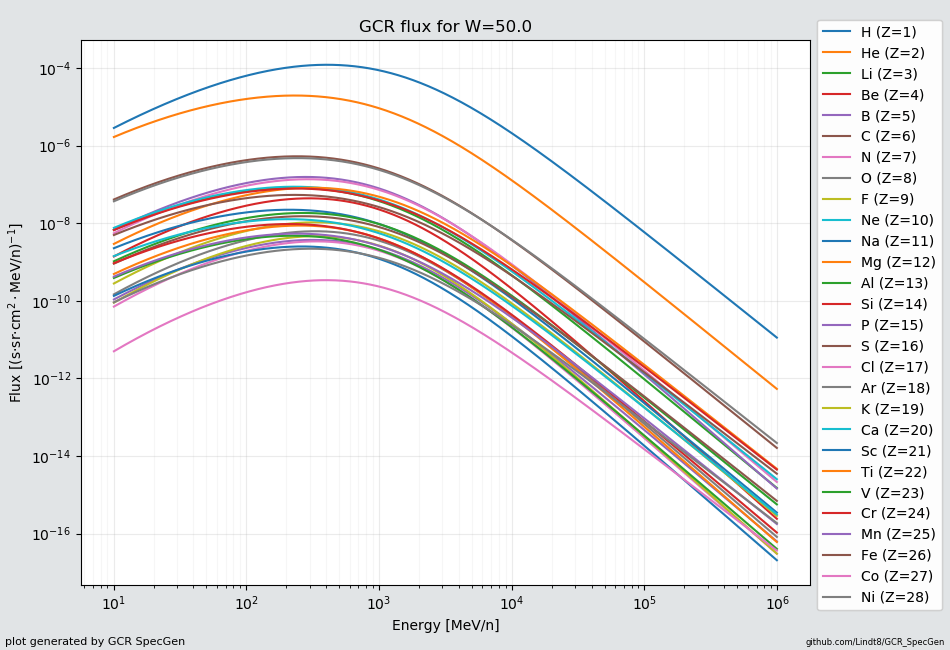

In [7]:
# Plotting

fig = plt.figure()
bg_color = '#E1E4E6'
fig.patch.set_facecolor(bg_color)
fig.patch.set_alpha(1.0)
l_corner_logo_text = 'plot generated by GCR SpecGen'
l_corner_logo_fs = 8
r_corner_logo_text = 'github.com/Lindt8/GCR_SpecGen'
r_corner_logo_fs = 6
fig.text(0.005,0.005,l_corner_logo_text,fontsize=l_corner_logo_fs,horizontalalignment='left',verticalalignment='bottom')
fig.text(0.995,0.005,r_corner_logo_text,fontsize=r_corner_logo_fs,horizontalalignment='right',verticalalignment='bottom')
ax = plt.subplot(111)
for i in range(28):
    Z = i+1
    legstr = all_Z_strs[i] + ' (Z='+str(Z)+')' # all_iso_strs_TeX[i]
    plt.plot(GCR_flux[i,1,:],GCR_flux[i,3,:],label=legstr)


# hangle figure/legend positioning/sizing
# First, figure size
default_fig_x_in = 9.5
default_fig_y_in = 6.5

# first, try getting widget widths from below; otherwise, use defaults
if currently_updating_fig_dims:
    fig_x_in = adjust_w_slider.value
    fig_y_in = adjust_h_slider.value
else:
    fig_x_in = default_fig_x_in
    fig_y_in = default_fig_y_in

fig.set_size_inches(fig_x_in,fig_y_in)
    
legend_type = 'outside_right'
if legend_type == 'outside_right':
    # Add primary legend
    leg1_anchor = (1.0, 1.05) # varied items 
    handles_l1, labels_l1 = ax.get_legend_handles_labels()
    # remove the errorbars
    if len(handles_l1)>0:
        handles_l1 = [h for h in handles_l1]
        legend1 = ax.legend(handles_l1, labels_l1,loc='upper left',bbox_to_anchor=leg1_anchor,ncol=1)
        ax.add_artist(legend1)
        # Change marker in legend
        #for l in legend1.get_lines():
        #    #l.set_alpha(1)
        #    l._legmarker.set_marker('s')
        #    l._legmarker.set_markersize(12)
    

good_to_go = True
if good_to_go: # stuff that will error out code on first initialization
    fig.canvas.draw()
    f1 = legend1.get_frame()
    l1_w0_px, l1_h0_px = f1.get_width(), f1.get_height()
    l_w0_in, l_h0_in = l1_w0_px/fig.dpi, l1_h0_px/fig.dpi # max legend dimensions in inches
    
    # Determine relative dimensions of plot
    x0bar = 0.8075 # inches, horizontal space needed for ylabel
    y0bar = 0.6500 # inches, vertical space needed for xlabel alone
    t0bar = 0.4000 # inches, vertical space needed for title
    del_l_in = 0.15 # inches, extra horizontal padding right of legend

    x0 = x0bar/fig_x_in
    y0 = y0bar/fig_y_in
    h0 = 1 - (y0bar+t0bar)/fig_y_in
    w0 = 1 - x0 - (l_w0_in/fig_x_in) - (del_l_in/fig_x_in)
    
    # Set size and location of the plot on the canvas
    box = ax.get_position()
    # all vals in [0,1]: left, bottom, width, height
    ax.set_position([x0, y0, w0, h0])
    
    
plt.xlabel('Energy [MeV/n]')
plt.ylabel(r'Flux [(s$\cdot$sr$\cdot$cm$^2\cdot$MeV/n)$^{-1}$]')
title_text = 'GCR flux for W='+str(W)
plt.title(title_text)
#plt.legend(loc='best')
plt.xscale('log')
plt.yscale('log')
plt.grid(b=True, which='major', linestyle='-', alpha=0.25)
plt.grid(b=True, which='minor', linestyle='-', alpha=0.10)
plt.show()

In [8]:
# Output options for text files, NumPy matrix, Spreadsheet (?), MCNP input, PHITS input